In [1]:
from assignment2 import *


Remise électronique sur ZoneCours au plus tard le **14 avril à 23h55** de:

* Ce Jupyter notebook (.ipynb) en guise de rapport, une fois les réponses ajoutées. 
* **Tous** les fichiers *.py* nécessaires pour l'exécution du notebook

Le rapport **doit**:

* être en format .ipynb (des points seront enlevés pour tout autre format).
* inclure le numéro de matricule de tous les membres de l'équipe dans la première cellule (i.e. remplacez ces consignes)
* répondre aux questions et discuter des résultats à l'aide de tables, graphiques, et cellules markdown

Barème:

* **35%** Exactitude des résultats
* **25%** Discussions complètes et **concises** (cellules ``markdown'')
* **20%** Concision du notebook (.ipynb avec minimum de code) et clarté des tables & graphiques
* **20%** Clarté du code (.py)

Dans les tables, présentez 4 décimales après le point.

# Question 1

Nous considérons des données historiques d'options sur le S&P 500. Le fichier suivant sont dans le répertoire courant:
```
215K 28 Mar 20:48 distrd_108105.csv
2.7M 28 Mar 21:01 opprcd200201_108105.csv
 63K 28 Mar 21:02 opprcd961203_108105.csv
511K 28 Mar 20:45 secprd_108105.csv
9.3M 28 Mar 20:43 zerocd.csv
```

Les `secprd_108105.csv` et `zerocd.csv` contiennent, respectivement, les données sur le sous-jacent et la courbe des taux sans risque (capitalisés continuement). La fonction `get_log_excess_returns` (fournie dans `assignment2.py`. 

In [86]:
days_in_year = 252
log_xreturns = get_log_excess_returns(days_in_year)

Utilisez les paramètres initiaux suivants pour démarrer l'estimation des paramètres d'un modèle NGARCH en date du 1996-12-31. Utilisez la notation suivante:

\begin{align*}
r_{t+1} - r_{f} &= \lambda \sqrt{h_{t+1}}-\frac{1}{2}h_{t+1}+\sqrt{h_{t+1}}%
\varepsilon _{t+1}, \\
h_{t+1}& =\omega +\alpha h_{t}\left( \varepsilon _{t}-\gamma \right)
^{2}+\beta h_{t}  
\end{align*}

In [87]:
#Initial conditions
time_t = np.datetime64('1996-12-31')
ng96 = ngarch.initialize_at(time_t, log_xreturns, days_in_year);

time_t2 = np.datetime64('2020-02-01')
ng20 = ngarch.initialize_at(time_t2, log_xreturns, days_in_year);

ngarch(
    lmbda = 0.01049,
    omega = 3.8227532878237797e-07,
    alpha = 0.06253,
    beta = 0.90825,
    gamma = 0.5972,
    days_in_year = 252
)
Persistence: 0.9930811894352
Unconditional volatility: 0.11799746729790572
ngarch(
    lmbda = 0.01049,
    omega = 9.523671067761848e-07,
    alpha = 0.06253,
    beta = 0.90825,
    gamma = 0.5972,
    days_in_year = 252
)
Persistence: 0.9930811894352
Unconditional volatility: 0.18624590986990416


Quels paramètres obtenez vous en maximisant la vraisemblance des rendements au 1996-12-31? Répétez l'exercice au 2020-02-01. Tabulez les paramètres de façon à pouvoir comparer les deux jeux de paramètres aisément. Ajoutez à votre table 

- la volatilité inconditionnelle (annualisée)
- la volatilité conditionnelle (annualisée) prédite au lendemain de l'estimation
- la correlation conditionnelle en $t$ entre $r_{t+1}$ et $h_{t+2}$
- la volatilité conditionnelle en $t$ de la variance $h_{t+2}$

que les paramètres impliques. De plus, inspirez-vous de la `note_on_erp.ipynb` et définissez une fonction:
```
def plot_var_forecasts(horizon, P, Q, annualized=False):
```
que vous appelerez avec `annualized=True` sur des simulations résultant des deux différents jeux de paramètres. Discutez des paramètres, des figures et des implications aux point de vue de la validité de la spécification (vs *misspecification*) du NGARCH.

In [88]:
#Estimation of Ngarch parameters

ng96 = f_NGARCH(ng96)
ng20 = f_NGARCH(ng20)


In [89]:
#Compare les paramètres
ng_res = [ng96, ng20]

res = {'λ'      : ["{:.4e}".format(ng.lmbda) for ng in ng_res], 
        'ω'      : ["{:.4e}".format(ng.omega) for ng in ng_res],
        'α'      : ["{:.4e}".format(ng.alpha) for ng in ng_res],
        'β'      : ["{:.4e}".format(ng.beta)  for ng in ng_res],
        'Vol Incond' : ["{:.4e}".format(np.sqrt(ng.uncond_var() * ng.days_in_year))  for ng in ng_res],
        'Vol @ T+1': ["{:.4e}".format(np.sqrt(ng.P_predict_h() * ng.days_in_year)) for ng in ng_res],
        'Correlation @ T+1': ["{:.4e}".format(ng.corr_ret_var()) for ng in ng_res],
        'Vol @ T+2': ["{:.4e}".format(np.sqrt(ng.cond_var())) for ng in ng_res]}
result_param = pd.DataFrame(data = res, index=[time_t, time_t2])
result_param

,λ,ω,α,β,Vol Incond,Vol @ T+1,Correlation @ T+1,Vol @ T+2
1996-12-31,4.7204e-02,5.1517e-06,7.8759e-03,1.1480e-08,1.2198e-01,1.3240e-01,-9.9783e-01,1.1771e-05
2020-02-01,2.9207e-02,2.4463e-06,8.4126e-02,7.8411e-01,2.0396e-01,1.6425e-01,-8.5759e-01,2.4763e-05


In [90]:
#Simulation 

# Inputs pour les simulations
S_t0    = 100
n_days  = 10*days_in_year
n_paths = 10000 

# Simulation sous P
P_96 = measure( *ng96.simulateP(S_t0,n_days,n_paths,ng96.P_predict_h()))
P_20 = measure( *ng20.simulateP(S_t0,n_days,n_paths,ng20.P_predict_h()))

# Simulation sous Q
Q_96 = measure( *ng96.simulateQ(S_t0,n_days,n_paths,ng96.Q_predict_h()))
Q_20 = measure( *ng20.simulateQ(S_t0,n_days,n_paths,ng20.Q_predict_h(),))



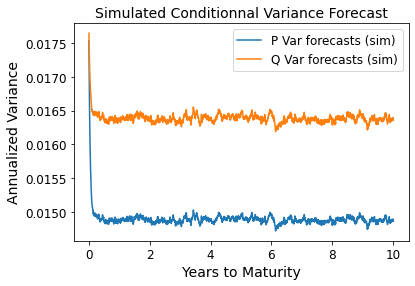

In [91]:
# Graphique des variances conditionnelles prévues
horizon    = np.arange(1,n_days+2) / days_in_year

plt_1996 = plot_var_forecasts(horizon, P_96, Q_96, annualized=True)




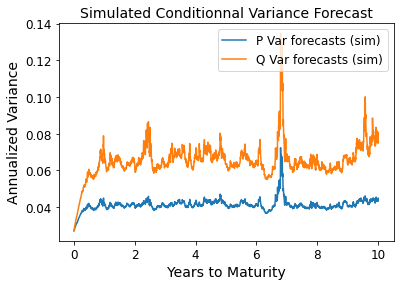

In [92]:
plt_2020 = plot_var_forecasts(horizon, P_20, Q_20, annualized=True)


# Question 2

Nous souhaitons tarifer les options aux deux dates pour lesquelles nous avons estimé les paramètres ci-haut. Avant de procédez, comparer qualitativement les deux jeux de données. Soutenez votre propos à l'aide de statistiques descriptives (tables) et de figures au besoin. Quels filtres devrait-on appliquer aux données avant procéder à la tarification des options? Justifier.

In [93]:
options96 = pd.read_csv('opprcd961203_108105.csv', index_col=0).reset_index(drop=True)
options20 = pd.read_csv('opprcd200201_108105.csv', index_col=0).reset_index(drop=True)


spx = pd.read_csv('secprd_108105.csv', index_col=0).reset_index(drop=True)
spx['date'] = pd.to_datetime(spx['date']) # convert str to actual dates

In [94]:
#option96_C = options96[options96["cp_flag"]=="C"]
#option96_P = options96[options96["cp_flag"]=="P"]

options_info = pd.concat([options96, options20])
options_info.dropna(subset=['impl_volatility'], how='any', inplace=True)



In [95]:
#Aller chercher la moneyness de chaque option + DTM




def f_moneyness(options, spx):
    options["moneyness"] =  np.zeros(len(options.index))
    
    date = options["date"].unique()
    
    prices = [spx[spx["date"] == d]["close"] for d in date]
    options.loc[:, ["strike_price"]]= options["strike_price"].div(1000)
    for i in range(len(prices)):
        
        options.loc[options["date"] == date[i], "moneyness"]  = options[options["date"] == date[i]]["strike_price"].div(float(prices[i]))
        
    return options

def f_DTM(options):
    
    options["DTM"] = np.array(options['exdate'], dtype='datetime64') - np.array(options['date'], dtype='datetime64')
    options["DTM"] = options["DTM"].dt.days
    return options



def f_add_info(options, spx):
    tmp = f_DTM(options)
    
    result = f_moneyness(tmp, spx)
    
    return result


info = f_add_info(options_info, spx)



In [96]:
#Options with the most open Interest and the moneyness

table = info.groupby(['date', 'cp_flag', 'DTM', 'moneyness']).agg({
                                    'open_interest': ['sum']
                                    })




table.loc["1996-12-03", :].sort_values(by=("open_interest","sum"), ascending = False)

open_interest
                                sum
cp_flag DTM moneyness              
C       109 0.90          33,394.00
P       109 0.87          27,930.00
C       109 0.84          25,481.00
P       200 0.87          21,718.00
            0.84          19,127.00
...                             ...
C       291 0.80               0.00
        200 1.08               0.00
        46  1.00               0.00
P       291 1.08               0.00
C       46  1.06               0.00

[325 rows x 1 columns]

In [97]:
#Sum open Interest in 1996 for SPX
table.loc["1996-12-03", slice(None)].sort_values(by=("open_interest","sum"), ascending = False)["open_interest"]["sum"].sum()

1025950.0

In [98]:
table.loc["2020-02-03", slice(None)].sort_values(by=("open_interest","sum"), ascending = False)

open_interest
                                 sum
cp_flag DTM  moneyness              
P       46   0.62          93,586.00
             0.92          78,170.00
C       46   0.99          67,688.00
P       46   0.99          66,283.00
C       46   1.01          66,015.00
...                              ...
        148  0.89               0.00
             0.89               0.00
             0.89               0.00
             0.88               0.00
P       1047 1.32               0.00

[11904 rows x 1 columns]

In [99]:
#Sum open Interest in 2020 for SPX
table.loc["2020-02-03", slice(None)].sort_values(by=("open_interest","sum"), ascending = False)["open_interest"]["sum"].sum()

14943405.0

On observe qu'il y a plus de open interest pour le marché des options en 2020-02-03 pour le spx avec 14 943 405 tandis qu'en 1996-12-03 on en compte 1 025 950 open Interest. D'ailleurs, la maturité ayant le plus d'open Interest est de 109 Jours en 1996-12-03 et 46 jours en 2020-02-03. Pour ce qui est de la moneyness (K/S) des options, on voit qu'en 1996 la moneyness du call et put du spx ayant le plus d'open interest est autour de 0.90. Tandis, qu'en 2020, la moneyness du call est à 0.99 et pour le put est OTM à 0.62

In [100]:
#Options with the most open interest for a certain DTM


table2 = info.groupby(['date', 'cp_flag', 'DTM']).agg({
                                    'open_interest': ['sum'],
                                    'moneyness': ['sum', 'min', 'max']
                                    })
table2.loc["1996-12-03", :].sort_values(by=("open_interest","sum"), ascending = False)


open_interest moneyness          
                      sum       sum  min  max
cp_flag DTM                                  
P       18     198,585.00     34.10 0.50 1.04
        109    172,379.00     34.19 0.60 1.14
C       109    119,536.00     28.46 0.83 1.14
P       200    113,037.00     19.26 0.53 1.14
        46      88,120.00     26.82 0.74 1.08
C       18      71,474.00     15.23 0.97 1.06
        46      55,043.00     21.80 0.91 1.08
        200     52,324.00     16.12 0.74 1.14
P       382     44,498.00     14.17 0.63 1.14
        291     31,240.00     12.70 0.80 1.14
C       382     20,618.00     14.17 0.63 1.14
P       81      18,487.00     15.67 0.74 1.08
        564     18,484.00     12.16 0.74 1.14
C       564      9,249.00     12.16 0.74 1.14
        81       7,342.00     14.93 0.91 1.08
        291      5,534.00     12.70 0.80 1.14

In [101]:
table2.loc["2020-02-03", slice(None)].sort_values(by=("open_interest","sum"), ascending = False)

open_interest moneyness          
                      sum       sum  min  max
cp_flag DTM                                  
P       46   2,362,400.00    545.50 0.31 1.32
        18   1,452,504.00    556.93 0.31 1.32
C       46   1,299,541.00    429.41 0.78 1.32
P       137  1,173,313.00    161.28 0.25 1.23
        319    984,036.00     82.25 0.03 1.20
...                   ...       ...  ...  ...
        30       2,390.00    123.83 0.62 1.17
C       35       1,733.00    113.64 0.82 1.17
P       35       1,529.00    123.83 0.62 1.17
        179          0.00    106.30 0.46 1.14
C       179          0.00    108.67 0.46 1.20

[78 rows x 4 columns]

Si on observe la somme des open interest pour divers maturités entre les deux dates, il y a quelques différences. EN 1996, la maturité ayant le plus d'open interest était : Call --> 109 jours et Put --> 19 jours. En 2020, c'étais : Call --> 46 jours et Put --> 46 jours. On remarque que la maturité de 46 jours étais la plus populaire en 2020 et qu'en 1996, les investisseurs aimaient les maturités plus courtes sur les puts.

In [102]:
def f_describe_table(option_info, spx):
    
    
    
    
    

    # Reorganize data and show descriptive table
    table = option_info.groupby(['date', 'cp_flag']).agg({
                                    'strike_price': ['count', 'min', 'max'],
                                    'impl_volatility': ['min', 'max'],
                                    'delta': ['min', 'max'],
                                    'DTM': ['min', 'max'],
                                    'moneyness': ['min', 'max', 'mean']
                                    })

    return table

In [103]:
f_describe_table(info, spx)

strike_price                   impl_volatility      delta  \
                          count      min      max             min  max   min   
date       cp_flag                                                             
1996-12-03 C                141   475.00   850.00            0.09 0.26  0.03   
           P                184   375.00   850.00            0.15 1.07 -0.88   
2020-02-03 C               6452 1,200.00 4,800.00            0.10 0.65  0.00   
           P               7837   100.00 4,300.00            0.06 2.90 -0.99   

                         DTM       moneyness            
                     max min   max       min  max mean  
date       cp_flag                                      
1996-12-03 C        0.97  18   564      0.63 1.14 0.96  
           P       -0.00  18   564      0.50 1.14 0.92  
2020-02-03 C        1.00   2  1047      0.37 1.48 0.93  
           P       -0.00   2  1047      0.03 1.32 0.88

D'ailleurs on voit qu'il y a beaucoup plus de maturités disponible pour les option en 2020 (somme des strikes)



In [104]:
#la surface de volatilité 3d entre les deux dates (DTM, IV, Moneyness)

option_C = info[info["cp_flag"]=="C"][info[info["cp_flag"]=="C"]["moneyness"] >= 1]
option_P = info[info["cp_flag"]=="P"][info[info["cp_flag"]=="P"]["moneyness"] <= 1]

In [105]:
df = pd.concat([option_C, option_P])
df

,secid,date,symbol,symbol_flag,exdate,last_date,cp_flag,strike_price,best_bid,best_offer,volume,open_interest,impl_volatility,delta,gamma,vega,theta,optionid,cfadj,am_settlement,contract_size,ss_flag,forward_price,expiry_indicator,root,suffix,DTM,moneyness
9,"108,105.00",1996-12-03,099F1.A3,0,1997-06-21,1996-12-03,C,775.00,28.88,29.88,1.00,"5,858.00",0.16,0.46,0.00,215.95,-41.36,"10,088,867.00",1.00,1.00,100.00,0,NaN,NaN,099F1,A3,200,1.04
13,"108,105.00",1996-12-03,09AD6.AD,0,1997-09-20,1996-11-26,C,800.00,27.75,29.75,0.00,111.00,0.16,0.40,0.00,253.85,-33.42,"10,147,501.00",1.00,1.00,100.00,0,NaN,NaN,09AD6,AD,291,1.07
25,"108,105.00",1996-12-03,09C09.9C,0,1997-02-22,1996-12-03,C,760.00,18.38,19.12,51.00,148.00,0.16,0.46,0.01,137.63,-59.79,"10,226,076.00",1.00,1.00,100.00,0,NaN,NaN,09C09,9C,81,1.02
28,"108,105.00",1996-12-03,09B71.FD,0,1996-12-21,1996-12-03,C,770.00,1.75,2.00,307.00,"2,724.00",0.13,0.17,0.01,39.51,-64.25,"10,187,261.00",1.00,1.00,100.00,0,NaN,NaN,09B71,FD,18,1.03
36,"108,105.00",1996-12-03,09D0C.83,0,1997-01-18,1996-12-03,C,810.00,0.81,1.06,57.00,298.00,0.14,0.06,0.00,31.42,-19.45,"10,292,355.00",1.00,1.00,100.00,0,NaN,NaN,09D0C,83,46,1.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16202,"108,105.00",2020-02-03,SPXW 201231P3125000,1,2020-12-31,2020-01-28,P,"3,125.00",151.60,152.70,0.00,12.00,0.17,-0.37,0.00,"1,160.96",-110.39,"131,821,294.00",1.00,0.00,100.00,0,NaN,m,NaN,NaN,332,0.96
16203,"108,105.00",2020-02-03,SPXW 201231P3150000,1,2020-12-31,2020-01-28,P,"3,150.00",159.20,160.30,0.00,21.00,0.17,-0.39,0.00,"1,176.38",-109.92,"131,821,295.00",1.00,0.00,100.00,0,NaN,m,NaN,NaN,332,0.97
16204,"108,105.00",2020-02-03,SPXW 201231P3175000,1,2020-12-31,2020-01-28,P,"3,175.00",167.00,168.30,0.00,11.00,0.16,-0.41,0.00,"1,189.68",-109.16,"131,821,296.00",1.00,0.00,100.00,0,NaN,m,NaN,NaN,332,0.98
16205,"108,105.00",2020-02-03,SPXW 201231P3200000,1,2020-12-31,2020-02-03,P,"3,200.00",175.30,176.50,2.00,15.00,0.16,-0.43,0.00,"1,200.58",-108.11,"131,821,297.00",1.00,0.00,100.00,0,NaN,m,NaN,NaN,332,0.98


In [110]:
df1996.values

array([[1.80000000e+01, 5.01149302e-01, 1.06610800e+00],
       [1.80000000e+01, 5.34559256e-01, 9.71855000e-01],
       [1.80000000e+01, 6.01379163e-01, 7.99238000e-01],
       [1.80000000e+01, 7.95156893e-01, 4.41297000e-01],
       [1.80000000e+01, 8.01838884e-01, 4.13284000e-01],
       [1.80000000e+01, 8.28566847e-01, 3.42494000e-01],
       [1.80000000e+01, 8.35248837e-01, 3.65755000e-01],
       [1.80000000e+01, 8.41930828e-01, 3.42005000e-01],
       [1.80000000e+01, 8.48612819e-01, 3.45201000e-01],
       [1.80000000e+01, 8.55294809e-01, 3.14239000e-01],
       [1.80000000e+01, 8.61976800e-01, 3.08958000e-01],
       [1.80000000e+01, 8.68658791e-01, 3.08416000e-01],
       [1.80000000e+01, 8.75340782e-01, 3.18092000e-01],
       [1.80000000e+01, 8.82022772e-01, 3.17105000e-01],
       [1.80000000e+01, 8.88704763e-01, 3.07292000e-01],
       [1.80000000e+01, 8.95386754e-01, 2.82072000e-01],
       [1.80000000e+01, 9.02068744e-01, 2.80205000e-01],
       [1.80000000e+01, 9.08750

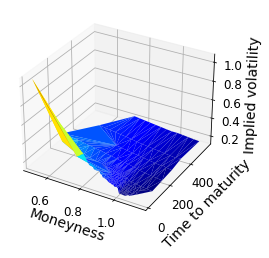

In [117]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

df1996 = df[df["date"] == "1996-12-03"][['moneyness', 'DTM' , 'impl_volatility']]



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(df1996['moneyness'],df1996['DTM'], df1996['impl_volatility'], cmap=plt.cm.jet, linewidth=0.2)
ax.set_ylabel('Time to maturity')
ax.set_xlabel('Moneyness')
ax.set_zlabel('Implied volatility')
plt.show()

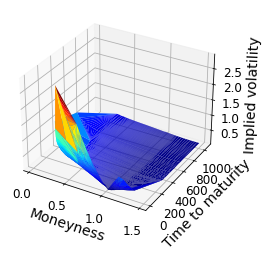

In [118]:

df2020 = df[df["date"] == "2020-02-03"][['moneyness', 'DTM' , 'impl_volatility']]



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(df2020['moneyness'],df2020['DTM'], df2020['impl_volatility'], cmap=plt.cm.jet, linewidth=0.2)
ax.set_ylabel('Time to maturity')
ax.set_xlabel('Moneyness')
ax.set_zlabel('Implied volatility')
plt.show()

# Question 3

Afin de tarifer les options, nous devons calculer, pour chaque paire $(t,T)$, le prix ex-dividendes du sous-jacent. Dans le cas du S&P 500, deux options s'offre à nous:

1. Utiliser en $t$ le taux de dividende prévu ($y$, en termes annuels) par OptionMetrics pour calculer $S(t) e^{-y(T-t)}$.

2. Utiliser l'approche du Cboe pour calculer le option-implied forward price $F(t,T)$ et la courbe des taux fournis par OptionMetrics (`zerocd.csv`). Ensuite, calculer le ex-dividend price $F(t,T) e^{-r_{t,T} (T-t)}$, où $r_{t,T}$ est le taux sans risque à $t$ pour une maturité à $T$, 

Comparer les résultats obtenus à les des deux approches. Comment et pourquoi diffèrent-ils selon vous? 

# Question 4

Notez que sous BMS, un call
\begin{align*}
 c(t,T,K) &= \hat{S}(t) N(d_1) - Ke^{-r_f(T-t)} N(d_2) \\
% \textrm{avec} 
 d_i &= \frac{\log\frac{\hat{S}(t)}{K} + \left(r_f \pm \frac{1}{2}\sigma^2 \right) (T-t)
     }{\sigma\sqrt{T-t}}
\end{align*}
avec $\hat{S}(t) = S(t)e^{-y(T-t)} = F(t,T)e^{-r_f(T-t)}$. L'argument est similaire pour un put. On peut donc calculer les volatilités implicites de chaque option avec l'approche utilisée dans le TP1, avec $y=0$, mais en utilisant les prix ex-dividendes obtenus en Question 3. 

Comparer les 2 volatilités implicites ainsi obtenues avec celle fournie par OptionMetrics (`impl_volatility`). Illustrer votre comparaison. 

# Question 5

Dans la même optique, dénotons $\tilde{R}_{t,T}^{(j)} = \exp\left\lbrace\sum_{k=1}^{T-t} r_{t+k}^{(j)} - r_f\right\rbrace$ le rendement excédentaire à terme obtenus par simulation du modèle NGARCH. Notez que le payoff actualisé d'une option peut être écrit 
\begin{align*}
  \mathcal{O}^{(j)}_{i} = e^{-r_{t,T_i} (T_i-t)}\max\left\lbrace 0, cp_i\left(F_{t,T_i} \tilde{R}_{t,T_i}^{(j)} - K\right) \right\rbrace
\end{align*}
où $cp_i = 1$ pour un call $i$ ($cp_i = -1$ pour le put $i$) de maturité $T_i$ et de strike $K_i$. Ainsi, seul $\tilde{R}_{t,T}^{(j)}$ dépend de la trajectoire simulée. En $t$, en simulant une seule fois 100,000 trajectoires de longueur $T_{max} - t$, il est donc possible de tarifer toutes les options observées ce jour là.

Procéder ainsi en utilisant l'un où l'autre des prix forward considérés en Question 3. Comparer les IV obtenues en Question 4, selon les prix de marché, avec les IV obtenus en appliquant la même méthode numérique au prix NGARCH. En particulier, tabuler les erreurs de tarifications, dans le domaine de la IV, en fonction d'intervalles de maturité et de moneyness.